<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> October 11, 2025 <strong>Author:</strong> Adnan Alaref
</div>

# **🎛️ Step 1: Core Idea**

Unlike **Gaussian** or **Masking noise** (which corrupt individual features),  
**Mixup noise** corrupts an *entire sample* by blending it with another sample.

$$
\tilde{x} = \lambda x_i + (1 - \lambda)x_j
$$

- **xᵢ**: original input  
- **xⱼ**: another random input from the dataset  
- **λ**: mixing coefficient, sampled from **Beta(α, α)**  
  - usually **α = 0.2** or **0.4**

## 🧩 Intuition

Instead of destroying features with random noise,  
**Mixup** makes your model see *interpolations between real samples.*

That teaches the DAE to:

- Learn **smoother latent manifolds**  
- Become **robust to unseen data**  
- **Avoid overfitting** to sharp input distributions

---

# **🧮 Step 2: Expert-Level Math Insight**

$$
\tilde{x} = \lambda x_i + (1 - \lambda)x_j
$$

$$
\tilde{y} = \lambda y_i + (1 - \lambda)y_j
$$

For **DAEs**, you usually apply **Mixup** only to inputs,  
but if your DAE also predicts **structured outputs**,  
you can Mixup both **input** and **target**.

💡 **When we call about lables, how to Use Each:**

| **Scenario** | **Recommended Label Mixing** |
|---------------|------------------------------|
| 🧠 DAE / Regression / Continuous Target | ✅ Use `y_tilde = lam*y + (1 - lam)*y[index]` directly |
| 🎯 Classification (CrossEntropy) | ✅ Use `y_a`, `y_b` and combine losses manually |
| ⚙️ Custom Losses / VAEs / DAEs | 🟰 Either is fine, depending on architecture |

---

## 🧩 1️⃣ What Mixup Noise Really Means

Imagine you have two real images:

- 🐱 **Image A** → a cat  
- 🐶 **Image B** → a dog  

Each image is a tensor of pixel values between 0 and 1, e.g. shape **[3, 224, 224]**.

**Mixup** doesn’t destroy pixels randomly — it blends two entire images together like semi-transparent layers:

$$
x_{mixed} = \lambda \cdot x_{cat} + (1 - \lambda) \cdot x_{dog}
$$

---

## 🧠 2️⃣ Example Intuition

If **λ = 0.7**:

$$
x_{mixed} = 0.7 \times x_{cat} + 0.3 \times x_{dog}
$$

→ The new image looks **70% cat + 30% dog**, conceptually like this:

| Input A (Cat) | Input B (Dog) | Mixed |
|:-------------:|:-------------:|:------:|
| 🐱 | 🐶 | 🐱🐶 *blended image (semi-transparent)* |

It’s not *“corrupting”* in the usual sense — it’s creating a **smooth in-between example**.

---

## 🧮 3️⃣ What the DAE Learns

Let’s think about the DAE’s goal.

Normally, the DAE sees:

- $
x_{noisy} = x_{clean} + \text{random noise}
$

* and tries to reconstruct **x₍clean₎**.

With **Mixup noise**:
- $
x_{noisy} = \lambda x_i + (1 - \lambda) x_j
$

* and the DAE tries to reconstruct the clean **xᵢ**  (or both, weighted by **λ**).


So the DAE learns:

> “If I see an image halfway between two real examples,  
> I should be able to bring it back to one of the real ones.”

That teaches the model to:

- Distinguish **real** vs **interpolated** data  
- Learn **smooth latent transitions**  
- Become **robust to unseen samples**

---

## 🧩 4️⃣ Why It’s Used in DAEs and Modern Vision Tasks

| **Benefit** | **Description** |
|:-------------|:----------------|
| 🌈 **Smooth manifold learning** | DAE learns to reconstruct in-between image states. |
| 🧠 **Generalization** | Prevents overfitting by exposing the model to blended distributions. |
| 🧱 **Stability** | Reduces sharp transitions in pixel/feature space. |
| 💪 **Adversarial robustness** | Forces the model to behave linearly between samples. |

---

## ⚠️ 5️⃣ Common Pitfalls & Expert Notes

- ❌ **Don’t use very small α (< 0.1)** — it becomes nearly identical to real data.  
- ❌ **Don’t use very large α (> 1)** — mixed images become too unrealistic.  
- ⚙️ **Use Mixup before feeding the image into the DAE**, not after encoding.  
- 🎨 **Works best with autoencoders trained on RGB normalization** (0–1 or −1–1).

---

## 🔥 6️⃣ Key Takeaway

| **Classic Noise** | **Mixup Noise** |
|:------------------|:----------------|
| Adds random fuzz | Blends two real samples |
| Local change in pixels | Global smooth interpolation |
| Non-semantic (random) | Semantic (still meaningful) |
| DAE denoises back to same sample | DAE learns smooth transitions between samples |

---

# **☠ Step 3: Expert Tips**

- ✅ **Use** `MSELoss` **or** `SmoothL1Loss (Huber)` **for reconstruction.**  
- ✅ **Keep** α = 0.2–0.4 **for natural Mixup intensity.**  
- ✅ **If using normalization** (e.g., mean/std), **apply the same to mixed images.**  
- ✅ **Combine with Gaussian noise** — stacking both improves robustness.

---

### **Let's Code**

## **◍ Import Libraries.**

In [1]:
import torch
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore' ,category=FutureWarning)

## **◍ Mixup Two Images.**

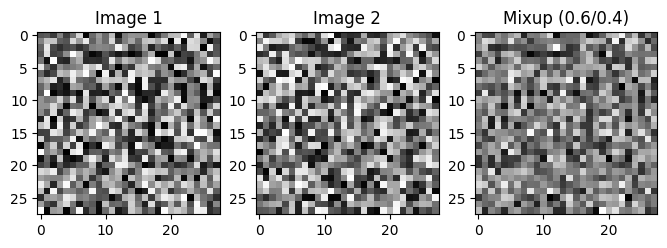

In [2]:
# Two fake images (for illustration)
x1 = torch.rand(1, 28, 28)
x2 = torch.rand(1, 28, 28)

lam = 0.6  # 60% first image, 40% second image
x_mix = lam * x1 + (1 - lam) * x2

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(x1.squeeze(), cmap='gray')
axes[0].set_title("Image 1")
axes[1].imshow(x2.squeeze(), cmap='gray')
axes[1].set_title("Image 2")
axes[2].imshow(x_mix.squeeze(), cmap='gray')
axes[2].set_title("Mixup (0.6/0.4)")
plt.show()

## **◍ Define mixup function for noise injection.**

In [3]:
def mixup_noise(x, alpha=0.4):
  """Applies Mixup noise to a batch of samples."""
  batch_size = x.size(0)

  # Sample mixing coefficient from Beta distribution
  # lam = float(torch.distributions.beta(alpha,alpha).sample()) Or
  lam = np.random.beta(alpha,alpha)

  # Shuffle indices for mixing
  indx = torch.randperm(batch_size)

  # Mix samples
  x_mix = lam * x + (1-lam)* x[indx,:]
  return x_mix ,lam

#-----------Call----------#
x = torch.rand(4,3)
x_mix ,lam = mixup_noise(x,alpha=0.4)
print(f"X :",x)
print(f"\nλ =   {lam:.3f}\n")
print(f"X_mixed :",x_mix)

X : tensor([[0.0264, 0.5579, 0.4962],
        [0.4121, 0.4915, 0.7243],
        [0.4793, 0.1900, 0.9760],
        [0.3707, 0.2406, 0.8846]])

λ =   0.982

X_mixed : tensor([[0.0264, 0.5579, 0.4962],
        [0.4121, 0.4915, 0.7243],
        [0.4774, 0.1909, 0.9744],
        [0.3726, 0.2397, 0.8862]])


## **◍ Define mixup function for images.**

In [4]:
def mixup_images(x, alpha=0.4):
  """Applies Mixup augmentation to a batch of images and labels."""

  batch_size = x.size(0)
  lam = torch.distributions.beta(alpha,alpha)

  # Shuffle indices for mixing
  index = torch.randperm(batch_size)

  # Mix images and labels
  x_mix = lam * x + (1-lam) * x[index,:]

  return x_mix, index, lam

#### Then during training (Forward):


```python
# Input mixup
x_mixed, idx, lam = mixup_images(x_clean, alpha=0.4)

# Model tries to reconstruct clean version
outputs = model(x_mixed)

# Weighted reconstruction target
loss = lam* criterion(outputs, x_clean) + (1-lam)* criterion(outputs, x_clean[idx])
```

# **⚒ Step 4: Compare Mixup in unsupervised DAEs vs Mixup in supervised CNNs.**

## 🧠 1️⃣ First, Recall What Each Model Tries to Learn

| Model | What it learns | What the target (`y`) is |
|:--|:--|:--|
| 🧱 **DAE (Denoising Autoencoder)** | Learns to reconstruct **clean input** from a **noisy version** | Target is the **same image (input itself)** |
| 🧠 **CNN Classifier** | Learns to predict a **class label** (e.g., cat/dog) | Target is a **class label (0, 1, 2, …)** |

---


## 🌀 2️⃣ Mixup in a DAE (Unsupervised)

In a **DAE**, there are no explicit class labels — only input–output pairs  
$$
(x_{\text{noisy}}, x_{\text{clean}})
$$

So we only apply **Mixup** to the **inputs** as a structured type of noise:
- x_noisy → blended image (λ * image_A + (1−λ) * image_B)
- output → reconstruction
- loss → reconstruct both clean images proportionally

🧩 The DAE is not predicting “cat” or “dog” — it’s learning how to unmix the blended input back into realistic data.



```python
# Input mixup
x_noisy, index, lam = mixup_images(x_clean, alpha=0.4)

# Model tries to reconstruct clean version
output = dae(x_noisy)

# Weighted reconstruction target
loss = lam * criterion(output, x_clean) + (1 - lam) * criterion(output, x_clean[index])
```


---

## 🎯 3️⃣ Mixup in a CNN Classifier (Supervised)

Now we **do have labels (`y`)**.  
So when we mix two images, we also need to **mix their labels**.

$$
x_{\text{mixed}} = \lambda x_i + (1 - \lambda) x_j
$$  
$$
y_{\text{mixed}} = \lambda y_i + (1 - \lambda) y_j
$$

### **There are two implementation styles** 👇

### ✅ Option A: Explicitly Mix Labels (for BCE or MSE losses)


```python
x_mixed, index, lam = mixup_images(x)
y_mixed = lam * y + (1 - lam) * y[index]
output = model(x_mixed)
loss = criterion(output, y_mixed)
```

### ✅ Option B: Weighted Losses (for CrossEntropy)


```python
x_mixed, index, lam = mixup_images(x)
output = model(x_mixed)
loss = lam * criterion(output, y) + (1 - lam) * criterion(output, y[index])
```

* Both are mathematically the same
* Option B is used more because **CrossEntropy** in PyTorch doesn’t accept soft labels directly

---
## 🧩 4️⃣ Mixup Utility Function (Common for Both)

In [5]:
def mixup_data(x: Tensor,
               y: Optional[Tensor] = None,
               alpha: float = 0.4
               )-> Union[
                   Tuple[Tensor,Tensor,Tensor,float],
                   Tuple[Tensor, Tensor,float]
               ]:
  """
    Perform Mixup data augmentation for both supervised and unsupervised learning.

    Parameters
    ----------
    x : torch.Tensor
        Input batch of data with shape (batch_size, ...).
    y : torch.Tensor, optional
        Target labels. If None, Mixup operates in unsupervised mode (e.g., DAE).
    alpha : float, default=0.4
        Beta distribution parameter controlling the mix strength.

    Returns
    -------
    Supervised mode (when y is provided):
        x_mixed : torch.Tensor
            The mixed batch of inputs.
        y_a : torch.Tensor
            Original labels.
        y_b : torch.Tensor
            Shuffled labels.
        lam : float
            Mixing coefficient sampled from Beta(α, α).

    Unsupervised mode (when y is None):
        x_mixed : torch.Tensor
            The mixed batch of inputs.
        index : torch.Tensor
            Shuffled indices used for mixing.
        lam : float
            Mixing coefficient.

    Notes
    -----
    - Mixup blends pairs of samples (x_i, x_j) as:
          x_mixed = λ * x_i + (1 - λ) * x_j
      and, if labels are available:
          y_mixed = λ * y_i + (1 - λ) * y_j
    - Typical α values: 0.2–0.4
    """
  # sample lambda from Beta(α, α)
  lam:float = float(torch.distributions.beta(alpha,alpha).sample())

  # create a random index permutation
  batch_size = x.size(0)
  indx = torch.randperm(batch_size)

  # Mix inputs
  x_mixed = lam*x + (1-lam)*x[indx,:]

  # for supervised
  if y is not None:
    y_a, y_b = y, y[indx]
    return x_mixed, y_a, y_b, lam

  # for DAE (unsupervised)
  else:
    return x_mixed, indx, lam

### **🔹 Training loop example:(DAE)**


```python
# Suppose we have: model, optimizer, criterion = MSELoss()
for x in dataloader:
    x = x.to(device)

    # Apply Mixup noise
    x_mix, index, lam = mixup_data(x, alpha=0.4)

    # Forward pass
    output = model(x_mix)

    # Compute weighted reconstruction loss
    loss = lam * criterion(output, x) + (1 - lam) * criterion(output, x[index, :])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

### **🔹 Training loop example:( CNN/Classifier)**


```python
# Suppose we have: model, optimizer, criterion = CrossEntropyLoss()
for x, y in dataloader:
    x, y = x.to(device), y.to(device)

    # Apply Mixup
    mixed_x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4)

    # Forward pass
    outputs = model(mixed_x)

    # Compute the Mixup loss
    loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

---

## 🔍 5️⃣ Conceptual Difference Summarized

| Aspect | 🧱 **DAE** | 🧠 **CNN Classifier** |
|:--|:--|:--|
| **Purpose** | Reconstruct original image | Predict class label |
| **Target (y)** | Image itself | Class label |
| **Mixup applied to** | Inputs only | Inputs and labels |
| **Label type** | None (unsupervised) | Required (supervised) |
| **Loss function** | MSELoss / SmoothL1Loss | CrossEntropyLoss / BCE |
| **Goal of Mixup** | Add smooth, semantic noise to inputs | Add smooth interpolation between classes |

---

## 💡 6️⃣ Expert Insight: Why This Matters

- In **DAEs** → Mixup = **noise injection**  
- In **CNNs** → Mixup = **regularization and smoothing**

🧩 Both use **the same formula**, but for **different motivations**:  
- DAEs care about **reconstruction stability**  
- Classifiers care about **decision boundary smoothness**

---

## ✅ 7️⃣  Summary

| Model Type | Mixup on `x` | Mixup on `y` | Training Goal |
|:--|:--:|:--:|:--|
| **DAE** | ✅ Yes (input noise) | ❌ No (no labels) | Reconstruct clean input |
| **CNN Classifier** | ✅ Yes | ✅ Yes | Predict interpolated labels |
| **VAE / Semi-Supervised Autoencoder** | ✅ Yes | (optional) ✅ | Combine both effects |

<a id="Import"></a>
<p style="background-color: #000000; font-family: 'Verdana', sans-serif; color: #FFFFFF; font-size: 160%; text-align: center; border-radius: 25px; padding: 12px 20px; margin-top: 20px; border: 2px solid transparent; background-image: linear-gradient(black, black), linear-gradient(45deg, #FF00FF, #00FFFF, #FFFF00, #FF4500); background-origin: border-box; background-clip: content-box, border-box; box-shadow: 0px 4px 20px rgba(255, 105, 180, 0.8);">
   Thanks & Upvote ❤️</p>